In [2]:
import os
import warnings
import sagemaker
import logging
import boto3
import time
import pandas as pd
import json
import botocore
from botocore.exceptions import ClientError
warnings.filterwarnings("ignore")


# ========================== low-level service client of the boto3 session ==========================
config = botocore.config.Config(user_agent_extra='bedissj-1699438736259')


sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

featurestore_runtime = boto3.client(service_name='sagemaker-featurestore-runtime', 
                                    config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime,
                         sagemaker_featurestore_runtime_client=featurestore_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# 1. Feature Engineering using Amazon SageMaker Processing Jobs

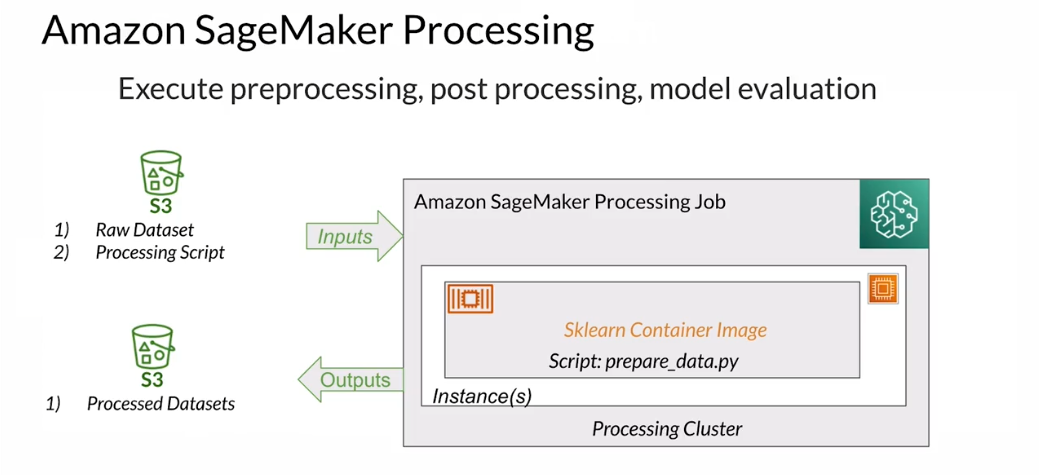

In [3]:
from sagemaker.sklearn.processing import SKLearnProcessor

# ========================== Processing Parameters ==========================
instance_type = 'ml.t3.medium'
instance_count = 1
max_runtime=7000


# ====================== Instanciate SKLearn Processor ======================
processor = SKLearnProcessor(
    framework_version='0.23-1',
    instance_type=instance_type,
    instance_count=instance_count,
    max_runtime_in_seconds=max_runtime,
    env={'AWS_DEFAULT_REGION': region},
    role=role,
)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
from sagemaker.processing import ProcessingInput, ProcessingOutput


# ======================== Processing Parameters ========================
raw_data_s3_uri = f's3://{bucket}/data/transformed_querying/month1'
input_data = '/opt/ml/processing/input/data'
output_data = '/opt/ml/processing/output'



# ========================== Processing Inputs ==========================
validation_split_percentage = 0.1
test_split_percentage = 0.2
feature_store_offline_prefix = None
feature_group_name = 'bank-churn-feature-group'



processing_inputs = [ProcessingInput(source=raw_data_s3_uri, 
                                     destination=input_data,
                                     s3_data_distribution_type='ShardedByS3Key')]



# ========================== Processing Outputs =========================
output_train_s3_uri = output_data + '/train'
output_val_s3_uri = output_data + '/validation'
output_test_s3_uri = output_data + '/test'
output_encoder_s3_uri = output_data + '/encoders'

processing_outputs = [
    ProcessingOutput(source=output_train_s3_uri,
                    output_name='bank-churn-train',
                    s3_upload_mode='EndOfJob'),
    
    ProcessingOutput(source=output_val_s3_uri,
                    output_name='bank-churn-validation',
                    s3_upload_mode='EndOfJob'),
    
    ProcessingOutput(source=output_test_s3_uri,
                    output_name='bank-churn-test',
                    s3_upload_mode='EndOfJob'),
    
    ProcessingOutput(source=output_encoder_s3_uri,
                    output_name='bank-churn-encoder',
                    s3_upload_mode='EndOfJob')
]



# ========================= Processing Arguments ========================
processing_args=[
    '--input-data', str(input_data),
    '--output-data', str(output_data),
    '--validation-split-percentage', str(validation_split_percentage),
    '--test-split-percentage', str(test_split_percentage),                        
    '--feature-store-offline-prefix', str(feature_store_offline_prefix),
    '--feature-group-name', str(feature_group_name),
    #'--role-arn', str(role),
]


In [5]:
processor.run(
    code='src/processing.py',
    inputs=processing_inputs,
    outputs=processing_outputs,
    arguments=processing_args,
    wait=False,
    logs=True
)


INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2024-03-06-21-05-51-569


In [10]:
print(processor.latest_job.describe().get('ProcessingJobName'))
print(processor.latest_job.describe().get('ProcessingJobArn'))
print(processor.latest_job.describe().get('ProcessingJobStatus'))

sagemaker-scikit-learn-2024-03-06-21-05-51-569
arn:aws:sagemaker:eu-west-3:668303144976:processing-job/sagemaker-scikit-learn-2024-03-06-21-05-51-569
InProgress


In [ ]:
# import pprint

# pprint.pprint(processor.latest_job.describe())

In [11]:
%%time

scikit_processing_job_name = processor.jobs[-1].describe()['ProcessingJobName']

running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=scikit_processing_job_name,
    sagemaker_session=sess
)

running_processor.wait(logs=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.2/406.2 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.2 MB/s eta 0:00:00
  Created wheel for sagemaker: filename=sagemaker-2.35.0-py2.py3-none-any.whl size=571606 sha256=f68db2715375ad13e5b71dbaf8d0702d00d900825d81fb6d7b5d4c6f76f19644
  Stored in directory: /root/.cache/pip/wheels/cf/a0/a7/7940176b9112f0e3f3650b928fece0dafbfaf603350370e46c
  Created wheel for protobuf3-to-dict: filename=protobuf3_to_dict-0.1.5-py3-none-any.whl size=4015 sha256=48fa7e037c37758deef7500f5ab12fc4eff1939bc8b4d83cac619a9409eb58a3
  Stored in directory: /root/.cache

In [12]:
print(processor.latest_job.describe().get('ProcessingJobStatus'))

Completed


In [17]:
!aws s3 cp './Data Processing & Feature Store.ipynb' s3://$bucket/Processing-Job/DataProcessingFeatureStore.ipynb
!aws s3 cp './src/processing.py' s3://$bucket/Processing-Job/processing.py

upload: ./Data Processing & Feature Store.ipynb to s3://sagemaker-eu-west-3-668303144976/Processing-Job/DataProcessingFeatureStore.ipynb
upload: src/processing.py to s3://sagemaker-eu-west-3-668303144976/Processing-Job/processing.py
